In [605]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

In [606]:
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)

In [607]:
#Importing data

train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')


X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')


X_test_estimated_a['building_id'] = 'a'
X_test_estimated_b['building_id'] = 'b'
X_test_estimated_c['building_id'] = 'c'

X_test = pd.concat([X_test_estimated_a,X_test_estimated_b,X_test_estimated_c])

X_train_estimated_a['building_id'] = 'a'
X_train_estimated_b['building_id'] = 'b'
X_train_estimated_c['building_id'] = 'c'

X_train_observed_a['building_id'] = 'a'
X_train_observed_b['building_id'] = 'b'
X_train_observed_c['building_id'] = 'c'

train_a['building_id'] = 'a'
train_b['building_id'] = 'b'
train_c['building_id'] = 'c'

all_observed_X = pd.concat([X_train_observed_a,X_train_observed_b,X_train_observed_c])
all_estimated_X = pd.concat([X_train_estimated_a,X_train_estimated_b,X_train_estimated_c])

all_X = pd.concat([all_observed_X,all_estimated_X])

all_y = pd.concat([train_a,train_b,train_c])
all_y = all_y.rename(columns={'time':'time_hour'})



In [608]:
X_test['time_hour'] = (X_test['date_forecast']).dt.floor('H')
X_test_aggregated = X_test.groupby(['building_id', 'time_hour']).mean().reset_index()
X_test_aggregated


,building_id,time_hour,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,a,2023-05-01 00:00:00,2023-04-30 07:00:04,2023-05-01 00:22:30,4.325,1.28675,912.700012,0.000000,0.000000,1061.550049,0.0,271.650024,0.000000,0.000000,0.000000,0.000000,74.949997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.674988,0.0,0.0,1000.549988,1006.799988,0.0,0.0,80.275002,1013.099976,NaN,0.0,0.0,0.0,0.0,16.026501,-10.541000,0.000,273.799988,74.949997,29907.500000,3.950,2.100,3.350,0.0
1,a,2023-05-01 01:00:00,2023-04-30 07:00:04,2023-05-01 01:22:30,4.275,1.28600,1482.099976,0.000000,0.000000,1075.100098,0.0,271.450012,0.000000,0.000000,0.000000,0.000000,77.474998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.150024,0.0,0.0,1000.049988,1006.299988,0.0,0.0,79.824997,1012.599976,NaN,0.0,0.0,0.0,0.0,30.497250,-7.894500,0.000,273.799988,77.474998,29519.074219,3.825,1.925,3.300,0.0
2,a,2023-05-01 02:00:00,2023-04-30 07:00:04,2023-05-01 02:22:30,4.150,1.28375,1791.300049,0.000000,0.000000,1200.400024,0.0,271.049988,0.000000,0.000000,0.000000,0.000000,88.099998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1012.674988,0.0,0.0,999.500000,1005.799988,0.0,0.0,78.000000,1012.049988,NaN,0.0,0.0,0.0,0.0,44.517250,-3.815500,0.000,273.849976,88.099998,31009.125000,3.650,1.750,3.200,0.0
3,a,2023-05-01 03:00:00,2023-04-30 07:00:04,2023-05-01 03:22:30,4.025,1.28200,2312.875000,10124.424805,11.675000,1179.849976,0.0,270.649994,9.375000,16845.226562,2.100000,3765.350098,68.599998,6.0,0.0,0.0,0.0,0.0,0.0,0.75,0.5,1012.174988,0.0,0.0,998.974976,1005.224976,0.0,0.0,75.625000,1011.525024,NaN,0.0,0.0,0.0,0.0,58.083000,1.412500,0.000,273.899994,68.599998,34552.500000,3.500,1.450,3.150,0.0
4,a,2023-05-01 04:00:00,2023-04-30 07:00:04,2023-05-01 04:22:30,3.900,1.28100,2198.299805,141748.593750,76.875000,920.049988,0.0,270.375000,47.400002,102209.703125,25.450001,49571.199219,66.300003,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1011.724976,0.0,0.0,998.549988,1004.750000,0.0,0.0,74.224998,1011.049988,NaN,0.0,0.0,0.0,0.0,71.341003,7.468500,0.000,273.924988,66.300003,35483.875000,3.325,1.300,3.050,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,c,2023-07-03 19:00:00,2023-07-02 07:00:31,2023-07-03 19:22:30,8.400,1.19675,3493.649902,475981.375000,84.775002,1967.375000,0.0,281.700012,32.200001,162567.531250,13.450001,53064.921875,87.474998,24.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,992.150024,0.0,0.0,977.575012,983.400024,0.0,0.0,71.650002,989.299988,NaN,0.0,0.0,0.0,0.0,306.688995,8.131001,0.100,286.850006,88.175003,41007.898438,2.175,1.900,-1.075,0.0
2156,c,2023-07-03 20:00:00,2023-07-02 07:00:31,2023-07-03 20:22:30,8.600,1.20000,3078.750000,183261.343750,24.549999,1449.500000,0.0,282.024994,13.875000,82875.351562,2.400000,28523.800781,78.074997,24.0,0.0,0.0,0.0,0.0,0.0,1.00,0.5,992.575012,0.0,0.0,977.974976,983.849976,0.0,0.0,75.324997,989.750000,NaN,0.0,0.0,0.0,0.0,319.703003,3.239500,0.000,286.450012,78.949997,41315.949219,2.200,2.000,-0.925,0.0
2157,c,2023-07-03 21:00:00,2023-07-02 07:00:31,2023-07-03 21:22:30,8.875,1.20350,2308.399902,36831.074219,1.225000,1543.650024,0.0,282.350006,1.250000,27210.250000,0.000000

In [609]:
all_observed_X['time_hour'] = all_observed_X['date_forecast'].dt.floor('H')

all_observed_X_aggregated = all_observed_X.groupby(['building_id', 'time_hour']).mean().reset_index()
all_observed_X_aggregated['time_hour'].head()


0   2019-06-02 22:00:00
1   2019-06-02 23:00:00
2   2019-06-03 00:00:00
3   2019-06-03 01:00:00
4   2019-06-03 02:00:00
Name: time_hour, dtype: datetime64[ns]

In [610]:
# define groups of variables

sun_features_list = ['clear_sky_energy_1h:J', 'clear_sky_rad:W', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'is_day:idx', 'is_in_shadow:idx', 'sun_elevation:d']

humidity_features_list = ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'dew_point_2m:K', 't_1000hPa:K']

snow_features_list = ['fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm']

cloud_height_features_list = ['ceiling_height_agl:m', 'cloud_base_agl:m']


all_groups = [sun_features_list,humidity_features_list,snow_features_list,cloud_height_features_list]
all_groups_names = ['sun','humidity','snow','cloud_height']
n_pca = [2,2,1,1]

In [611]:
all_data = all_observed_X_aggregated.merge(all_y,on=['time_hour','building_id'],how='left')

In [612]:
all_data.describe()

,time_hour,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,pv_measurement
count,88108,88108,88108.000000,88108.000000,73830.000000,8.810800e+04,88108.000000,82499.000000,88108.000000,88108.000000,88108.000000,8.810800e+04,88108.000000,8.810800e+04,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,4474.0,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,88108.000000,82026.000000
mean,2020-10-25 08:42:06.186044416,2020-10-25 09:04:36.140078592,6.265968,1.252165,2743.309326,5.614832e+05,155.967514,1737.146118,0.005760,275.836792,42.256962,1.521251e+05,54.136311,1.948910e+05,67.007027,12.298622,0.103743,0.008636,0.207519,0.025937,0.051872,0.504049,0.544409,1009.481262,0.005835,0.085182,995.695374,1001.811401,0.787791,0.010298,73.782669,1007.954712,250.0,0.316595,0.000031,0.000329,0.090440,179.590714,0.296660,0.060218,280.010681,73.753578,32888.949219,3.007170,0.749281,0.634119,0.000085,303.579799
min,2019-01-01 00:00:00,2019-01-01 00:22:30,0.500000,1.139250,27.799999,0.000000e+00,0.000000,27.900000,-1.000000,247.425003,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,944.375000,0.000000,0.000000,929.974976,935.750000,0.000000,0.000000,19.575001,941.549988,250.0,0.000000,0.000000,0.000000,0.000000,6.983000,-49.931999,0.000000,258.024994,0.000000,132.375000,0.025000,-7.225000,-8.400000,-0.100000,0.000000
25%,2019-12-23 21:00:00,2019-12-23 21:22:30,4.175000,1.227250,1049.331177,0.000000e+00,0.000000,624.412476,0.000000,271.225006,0.000000,0.000000e+00,0.000000,0.000000e+00,42.200001,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1001.700012,0.000000,0.000000,987.974976,994.049988,0.000000,0.000000,64.349998,1000.174988,250.0,0.000000,0.000000,0.000000,0.000000,93.990686,-16.571563,0.000000,275.324982,53.768751,16468.362305,1.650000,-1.250000,-0.650000,0.000000,0.000000
50%,2020-10-24 19:30:00,2020-10-24 19:52:30,5.725000,1.251000,1767.937500,2.676226e+04,4.650000,1197.074951,0.000000,275.725006,2.525000,1.824169e+04,0.000000,8.087500e+01,79.500000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,1010.400024,0.000000,0.000000,996.650024,1002.750000,0.000000,0.000000,76.199997,1008.875000,250.0,0.000000,0.000000,0.000000,0.000000,180.030251,0.132625,0.000000,279.399994,92.500000,37081.687500,2.650000,0.400000,0.675000,0.000000,0.000000
75%,2021-08-26 18:00:00,2021-08-26 18:22:30,8.150000,1.275500,3630.318848,9.114937e+05,260.387497,2086.262451,0.000000,281.175018,71.449997,2.569204e+05,37.275002,1.413341e+05,98.375000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1018.299988,0.000000,0.000000,1004.549988,1010.674988,0.000000,0.000000,85.300003,1016.825012,250.0,0.000000,0.000000,0.000000,0.100000,265.279434,17.500813,0.100000,284.600006,99.850006,48183.036133,4.000000,2.550000,1.825000,0.000000,183.712500
max,2022-10-21 01:00:00,2022-10-21 01:00

# Univariable study

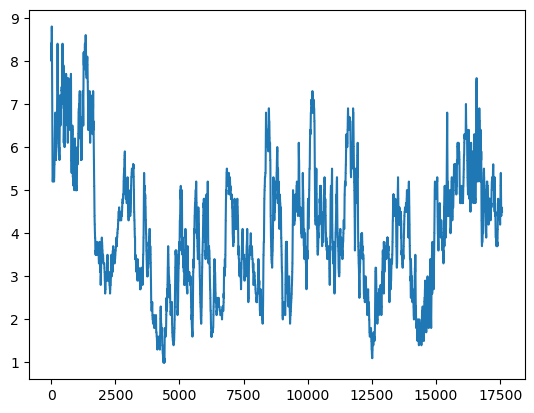

In [613]:

#absolute_humidity_2m:gm3 -> Absolute humidity at 2m level [g/m3]
plt.plot(X_train_estimated_a['absolute_humidity_2m:gm3']) #continuous values 

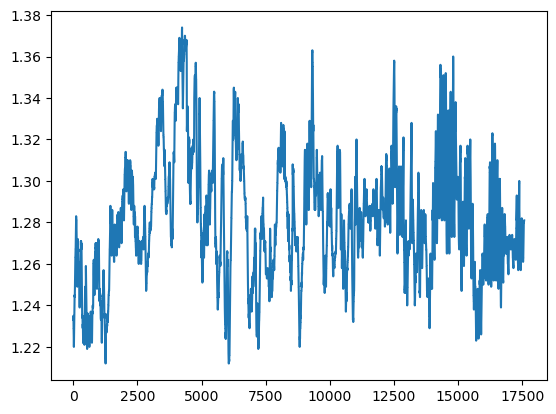

In [614]:
#air_density_2m:kgm3 -> atmospheric air density at 2m lvl [kg/m3]
plt.plot(X_train_estimated_a['air_density_2m:kgm3']) #continuous values 

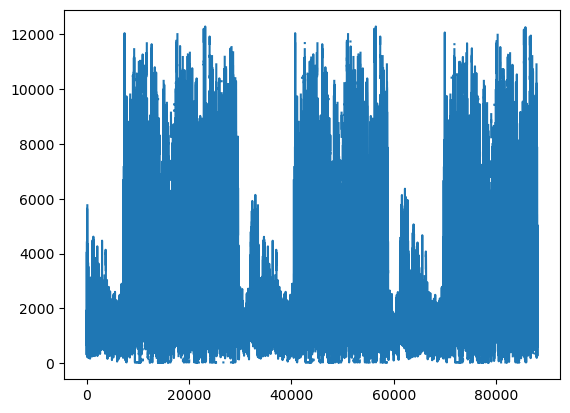

In [615]:
#ceiling_height_agl:m -> cloud height above ground level
plt.plot(all_data['ceiling_height_agl:m']) #continuous values 

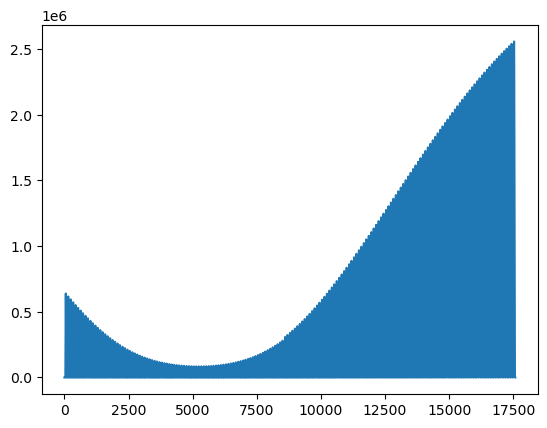

In [616]:
#clear_sky_energy_1h:J -> how much energy in 1h of clear sky
plt.plot(X_train_estimated_a['clear_sky_energy_1h:J']) # Seasonality?

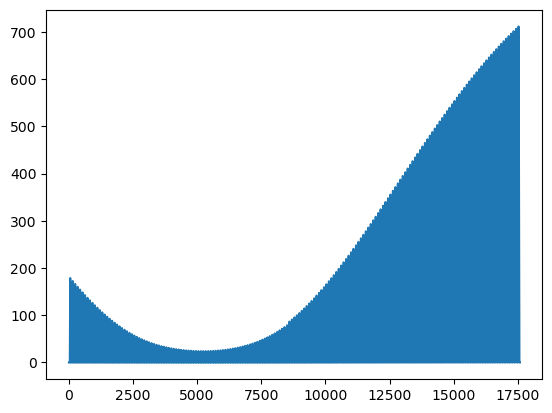

In [617]:
#clear_sky_rad:W -> how much radiation in 1h of clear sky
plt.plot(X_train_estimated_a['clear_sky_rad:W']) # Seasonality? Same as previous?

,building_id,time_hour,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,pv_measurement
134,a,2019-06-08 12:00:00,2019-06-08 12:22:30,10.475,1.18850,NaN,2.952455e+06,806.349976,NaN,0.0,285.350006,122.724998,494558.312500,588.549988,2.068820e+06,20.975000,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1009.924988,0.0,0.0,997.099976,1002.974976,0.0,0.0,63.599998,1008.875000,NaN,0.0,0.0,0.0,0.0,202.818253,47.820000,0.0,290.649994,37.799999,49054.523438,4.775,-3.25,-3.50,0.0,4457.86
135,a,2019-06-08 13:00:00,2019-06-08 13:22:30,10.875,1.18550,NaN,2.811238e+06,749.924988,NaN,0.0,285.950012,122.474998,441355.687500,524.575012,2.003657e+06,16.475000,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1009.349976,0.0,0.0,996.575012,1002.424988,0.0,0.0,64.250000,1008.325012,NaN,0.0,0.0,0.0,0.0,222.152252,44.224251,0.0,291.399994,27.200001,48945.500000,5.325,-3.40,-4.10,0.0,4289.34
269,a,2019-06-14 03:00:00,2019-06-14 03:22:30,9.500,1.22800,NaN,2.122680e+05,95.275002,NaN,0.0,283.549988,53.325001,131935.656250,24.150000,6.678812e+04,45.250000,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1015.674988,0.0,0.0,1002.950012,1008.950012,0.0,0.0,76.724998,1015.000000,NaN,0.0,0.0,0.0,0.0,54.207500,8.789750,0.0,286.075012,89.750000,40865.523438,2.150,-2.15,0.00,0.0,238.26
270,a,2019-06-14 04:00:00,2019-06-14 04:22:30,9.725,1.22175,NaN,5.201684e+05,198.674988,NaN,0.0,283.899994,80.974998,241791.078125,85.750000,1.978096e+05,38.049999,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1015.674988,0.0,0.0,1002.900024,1008.925049,0.0,0.0,75.600006,1014.925049,NaN,0.0,0.0,0.0,0.0,67.004501,14.626500,0.0,286.450012,75.150002,43029.425781,1.850,-1.85,-0.15,0.0,815.10
271,a,2019-06-14 05:00:00,2019-06-14 05:22:30,9.825,1.21475,NaN,9.355038e+05,323.174988,NaN,0.0,284.174988,115.724998,354095.968750,143.199997,4.120919e+05,38.000000,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1015.799988,0.0,0.0,1003.000000,1009.000000,0.0,0.0,72.449997,1015.000000,NaN,0.0,0.0,0.0,0.0,79.872002,21.046749,0.0,287.225006,74.375000,45633.625000,1.900,-1.85,-0.30,0.0,1001.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87919,c,2022-04-24 02:00:00,2022-04-24 02:22:30,4.175,1.28750,NaN,0.000000e+00,0.000000,NaN,0.0,271.150024,0.000000,0.000000,0.000000,0.000000e+00,2.700000,24.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1022.875000,0.0,0.0,1007.299988,1013.599976,0.0,0.0,57.849998,1019.875000,NaN,0.0,0.0,0.0,0.0,44.753750,-6.031500,0.0,278.399994,5.450000,36588.925781,2.000,-1.70,1.00,0.0,0.00
87920,c,2022-04-24 03:00:00,2022-04-24 03:22:30,4.100,1.28750,NaN,6.955000e+02,2.475000,NaN,0.0,271.100006,2.075000,3745.300049,0.000000,0.000000e+00,0.800000,24.0,0.0,0.0,0.0,0.0,0.0,0.25,1.0,1022.750000,0.0,0.0,1007.099976,1013.375000,0.0,0.0,59.474998,1019.700012,NaN,0.0,0.0,0.0,0.0,58.475250,-0.774000,0.0,278.125000,1.575000,37130.101562,1.900,-1.70,0.90,0.0,0.00
87921,c,2022-04-24 04:00:00,2022-04-24 04:22:30,4.275,1.28400,NaN,7.182212e+04,48.200001,NaN,0.0,271.524994,27.850000,53835.101562,21.975000,3.956330e+04,2.550000,24.0,0.0,0.0,0.0,0.0,0.0,1.00,0.5,1022.625000,0.0,0.0,1006.875000,1013.150024,0.0,0.0,60.674999,1019.450012,NaN,0.0,0.0,0.0,0.0,71.839752,5.312000,0.0,277.7

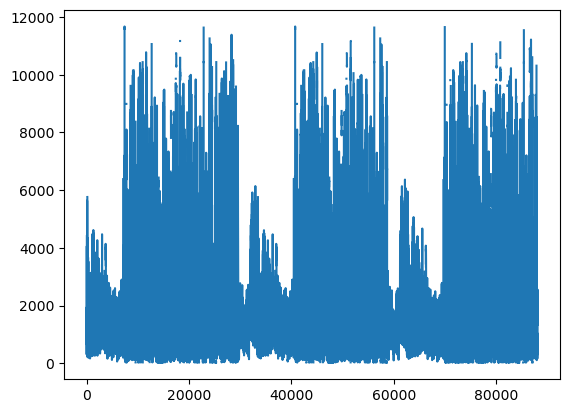

In [618]:
#cloud_base_agl:m -> lowest altitude of visible cloud
plt.plot(all_data['cloud_base_agl:m']) # continuous, correlated to ceiling?
all_data[all_data['cloud_base_agl:m'].isna()]

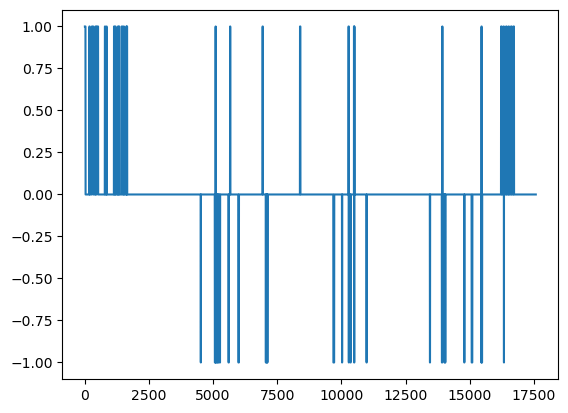

In [619]:
#dew_or_rime:idx -> dew or rime 
plt.plot(X_train_estimated_a['dew_or_rime:idx']) # {1 = dew, -1 = rime, 0 = none}

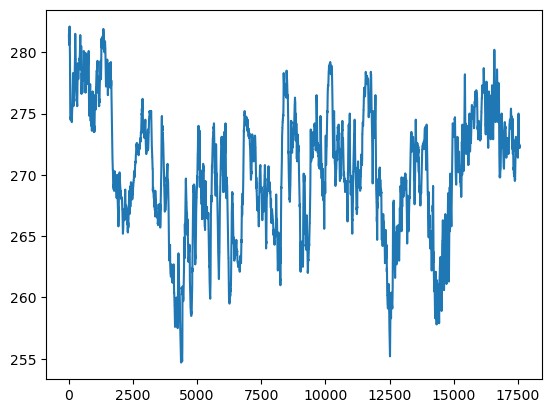

In [620]:
#dew_point_2m:K -> temperature at which the water vapor condenses into liquid
plt.plot(X_train_estimated_a['dew_point_2m:K']) # continuous -> correlated with water vapor in air

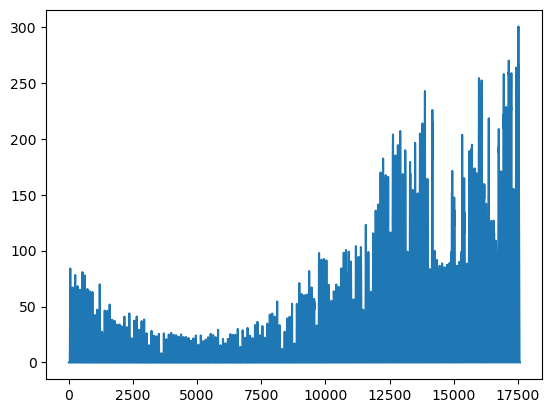

In [621]:
#diffuse_rad:W -> flux of diffuse radiation (not direct solar flux)
plt.plot(X_train_estimated_a['diffuse_rad:W']) # correlated with solar flux

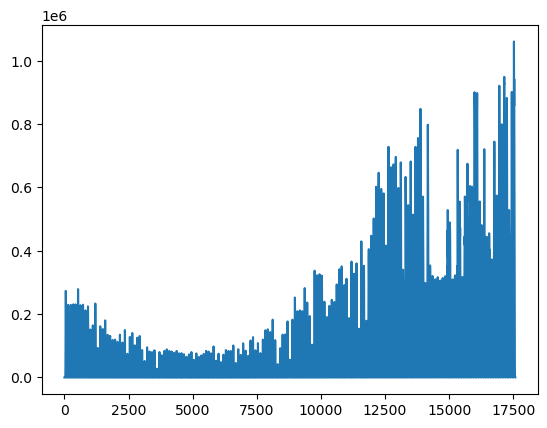

In [622]:
#diffuse_rad_1h:J -> flux of diffuse radiation in 1h
plt.plot(X_train_estimated_a['diffuse_rad_1h:J']) # same as previous?

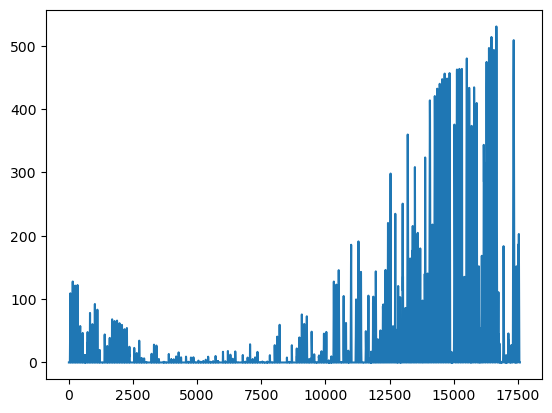

In [623]:
#direct_rad:W -> flux of direct radiation
plt.plot(X_train_estimated_a['direct_rad:W']) # correlated with clear sky

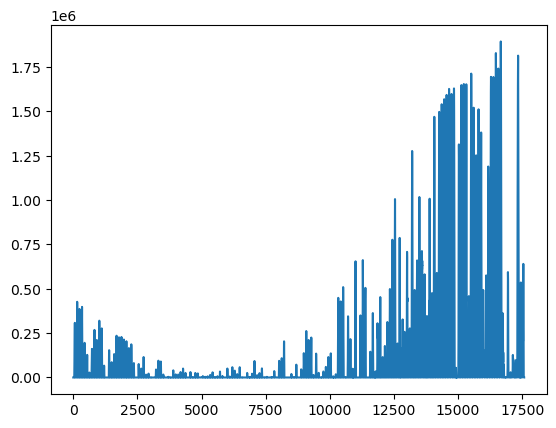

In [624]:
#direct_rad_1h:J -> flux of direct radiation
plt.plot(X_train_estimated_a['direct_rad_1h:J']) # same as previous

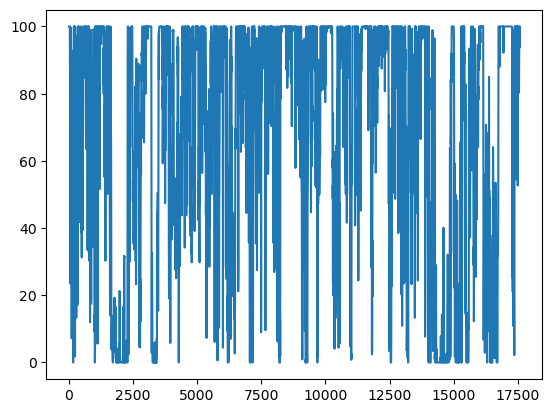

In [625]:
#effective_cloud_cover:p-> cloud covering of the sky !! -666 = no clouds
plt.plot(X_train_estimated_a['effective_cloud_cover:p']) # -666 values

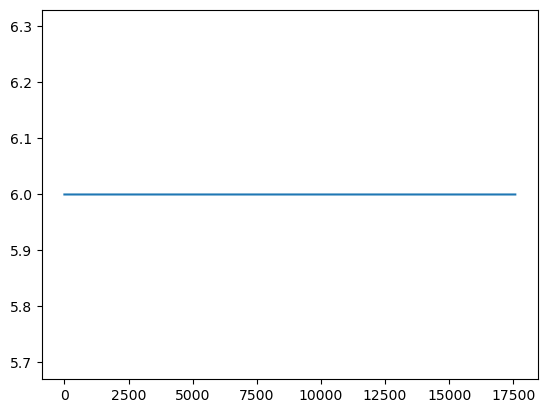

In [626]:
#elevation:m -> elevation of the building 
plt.plot(X_train_estimated_a['elevation:m']) # -const value dor building

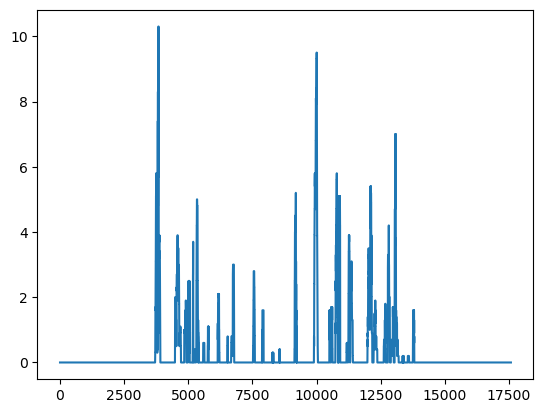

In [627]:
#fresh_snow_12h:cm -> amount in cm of fresh snow in hh hours
plt.plot(X_train_estimated_a['fresh_snow_12h:cm']) # continuous

#same for 12, 24, 1, 3, 6 h -> correlation

In [628]:
#is_day:idx -> if the sun is above horizon, seasonality?
X_train_estimated_a['is_day:idx'] # {0 = below horizon, 1 = above horizion}


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
17571    0.0
17572    0.0
17573    0.0
17574    0.0
17575    0.0
Name: is_day:idx, Length: 17576, dtype: float32

In [629]:
#is_in_shadow:idx -> if the sbuilding is in shadow -> correlation with previous?
X_train_estimated_a['is_in_shadow:idx'] # {0 = not in shadow, 1 = in shadow}

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
17571    1.0
17572    1.0
17573    1.0
17574    1.0
17575    1.0
Name: is_in_shadow:idx, Length: 17576, dtype: float32

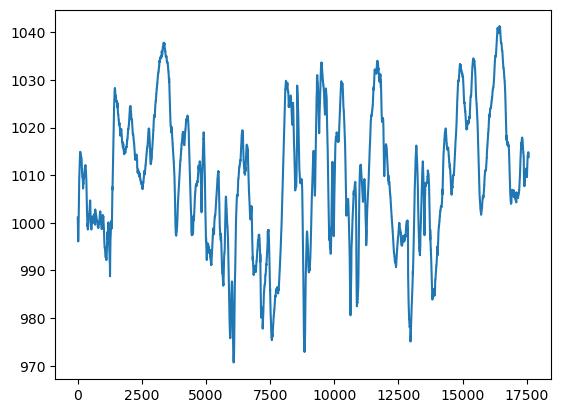

In [630]:
#msl_pressure:hPa -> mean sea level pressure
plt.plot(X_train_estimated_a['msl_pressure:hPa']) # correlation with other pressure misure?

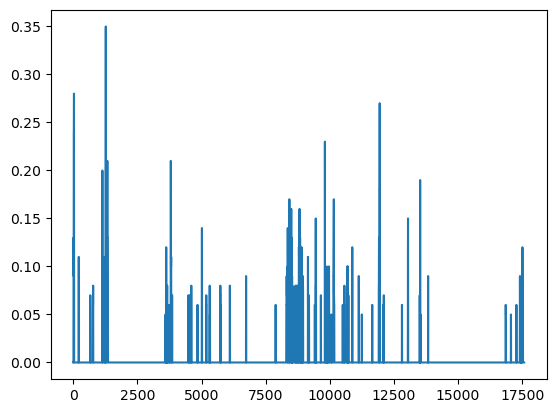

In [631]:
#precip_5min:mm -> rain in 5 min 
plt.plot(X_train_estimated_a['precip_5min:mm']) # 0 or continuous values

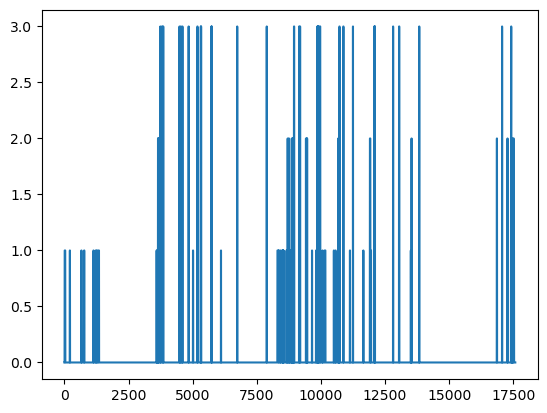

In [632]:
#precip_type_5min:idx -> 6 types of rain 
plt.plot(X_train_estimated_a['precip_type_5min:idx']) # categorical, correlated with precipitaion?
# 0 = None
# 1 = rain
# 2 = rain and snow mixed
# 3 = snow 
# 4 = sleet
# 5 = freezing rain
# 6 = Hail

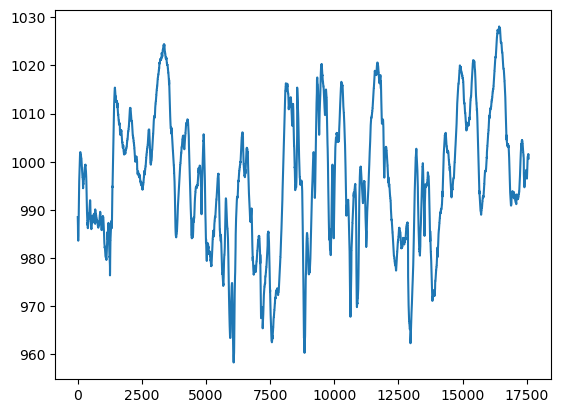

In [633]:
#pressure_100m:hPa -> pressure at x m -> correlated with pressures?
plt.plot(X_train_estimated_a['pressure_100m:hPa']) # continuous

# same for 50 m

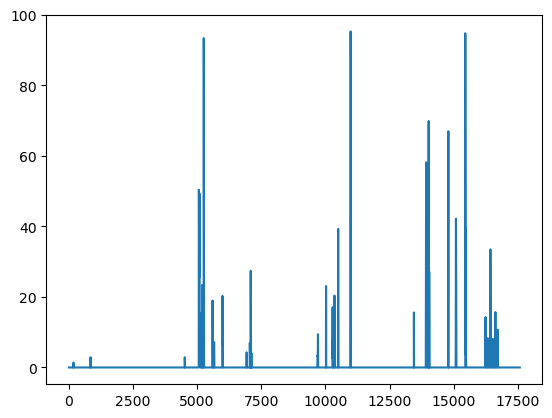

In [634]:
#prob_rime:p -> probability of rime
plt.plot(X_train_estimated_a['prob_rime:p']) # %

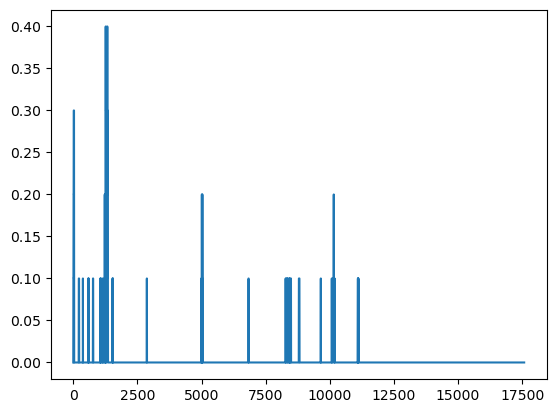

In [635]:
#rain_water:kgm2 -> how much rain in kg/m2
plt.plot(X_train_estimated_a['rain_water:kgm2']) # same as precipitation?

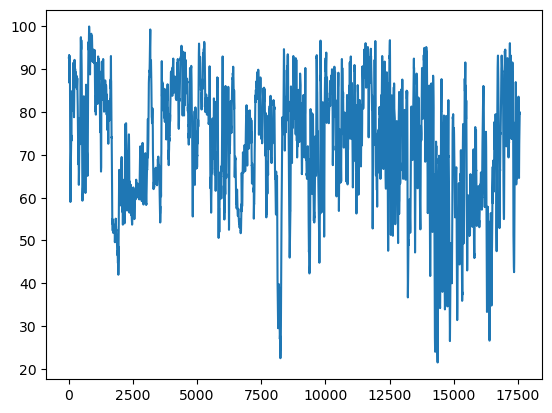

In [636]:
#relative_humidity_1000hPa:p -> humidity correlated with other?
plt.plot(X_train_estimated_a['relative_humidity_1000hPa:p']) # continuous 

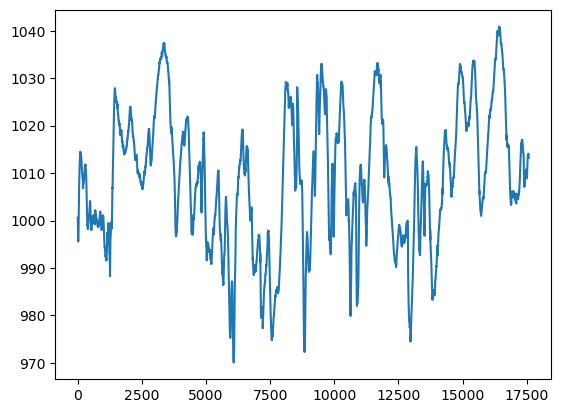

In [637]:
#sfc_pressure:hPa -> surface pressure, related with other pressures?
plt.plot(X_train_estimated_a['sfc_pressure:hPa']) # continuous 

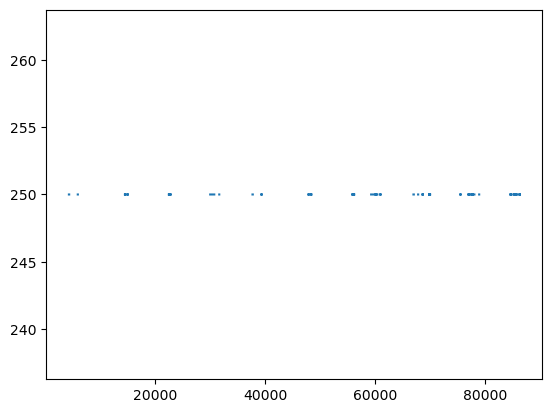

In [638]:
#snow_density:kgm3 -> seems always 250 (not significant?)
plt.plot(all_data['snow_density:kgm3']) # const if snow depth < 60 cm 

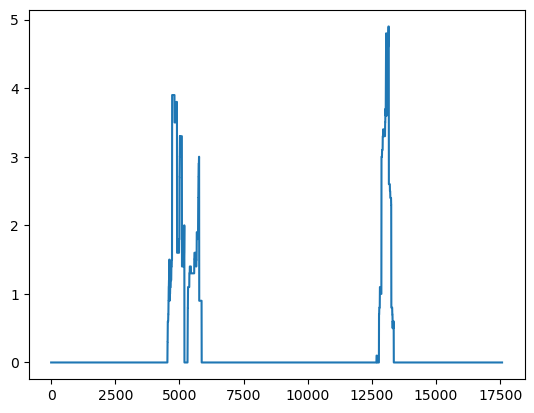

In [639]:
#snow_depth:cm -> snow depth in cm, correlated with snow
plt.plot(X_train_estimated_a['snow_depth:cm']) # 0 or continuous

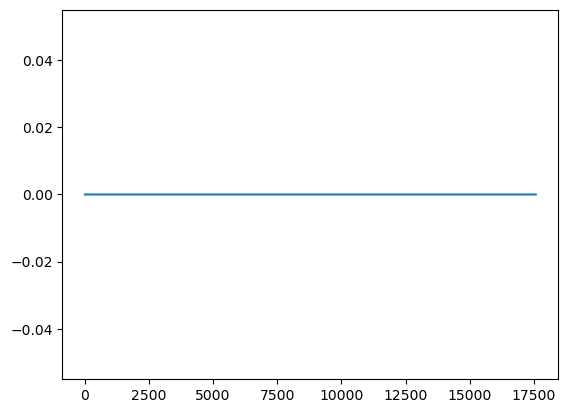

In [640]:
#snow_drift:idx -> index of snow carried over by wind seems always 0 (not significant?)
plt.plot(X_train_estimated_a['snow_drift:idx']) # categorical

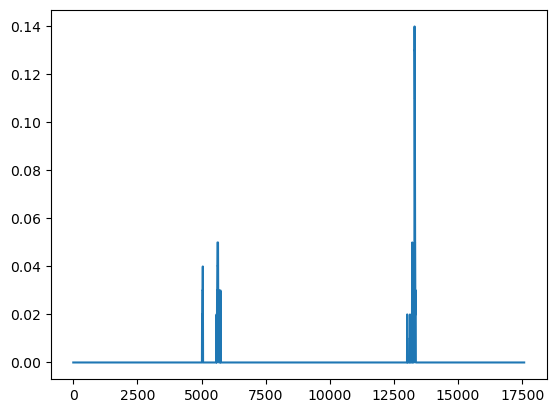

In [641]:
#snow_melt_10min:mm -> mm of melted snow in 10 min, correlated with snow?
plt.plot(X_train_estimated_a['snow_melt_10min:mm']) # 0 or continuous

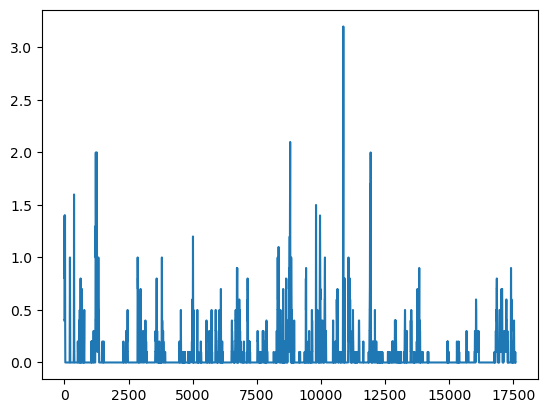

In [642]:
#snow_water:kgm2 -> snow converted in water? correlated with snow? 
plt.plot(X_train_estimated_a['snow_water:kgm2']) # 0 or continuous

<Axes: xlabel='date_forecast', ylabel='sun_azimuth:d'>

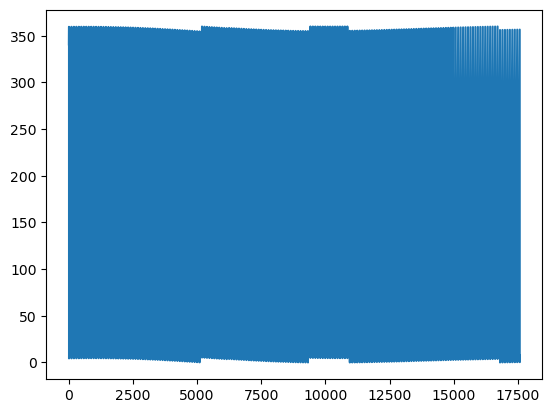

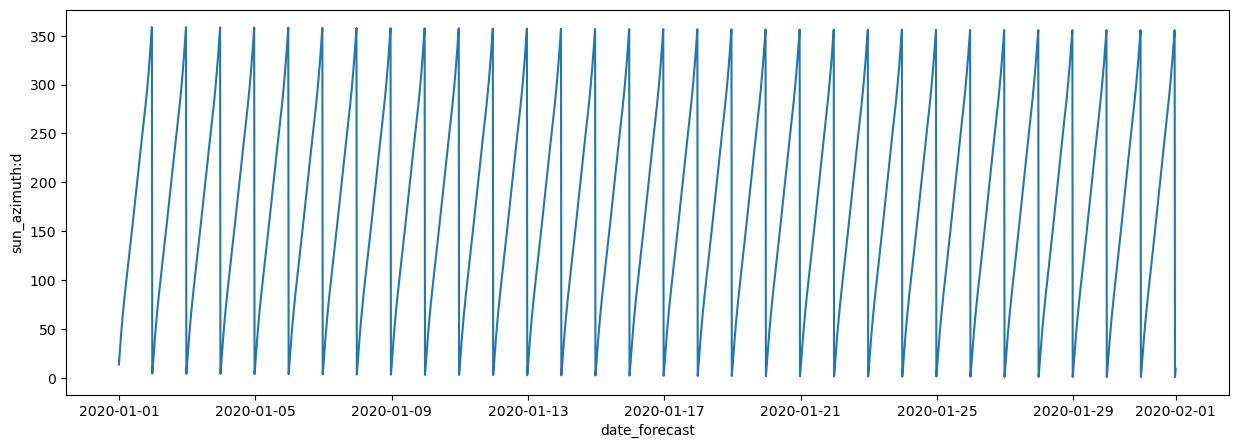

In [643]:
#'sun_azimuth:d' -> sun direction -> seasonality?
plt.plot(X_train_estimated_a['sun_azimuth:d']) # °
plt.figure(figsize=(15,5))
sns.lineplot(data=X_train_observed_a[X_train_observed_a['date_forecast'].between('2020-01-01','2020-02-01')],x='date_forecast',y='sun_azimuth:d')

<Axes: xlabel='date_forecast', ylabel='sun_elevation:d'>

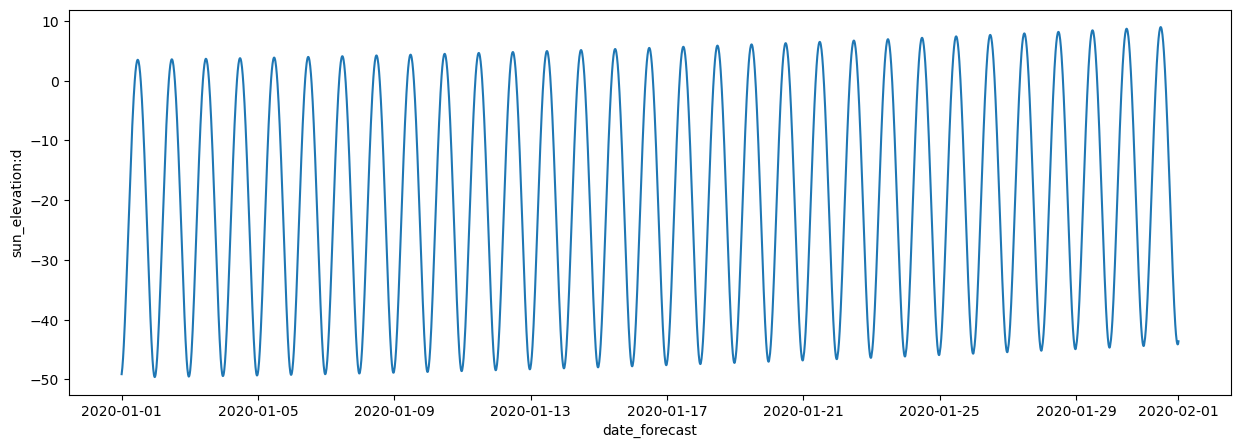

In [644]:
#'sun_elevation:d' -> sun elevation in degree -> seasonality
#plt.plot(X_train_observed_a['sun_elevation:d']) # °
plt.figure(figsize=(15,5))
sns.lineplot(data=X_train_observed_a[X_train_observed_a['date_forecast'].between('2020-01-01','2020-02-01')],x='date_forecast',y='sun_elevation:d')

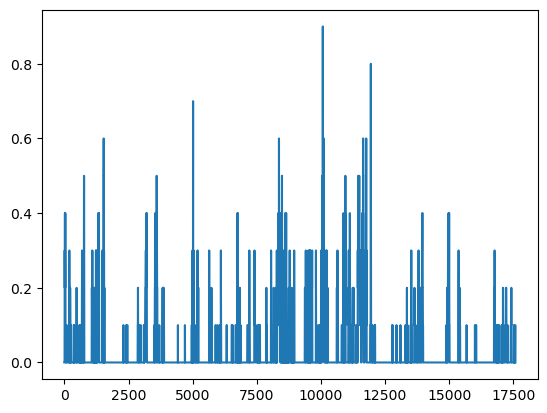

In [645]:
#'super_cooled_liquid_water:kgm2' -> super cooled water (under 0°C ) correlated with rain/snow?
plt.plot(X_train_estimated_a['super_cooled_liquid_water:kgm2']) # 0 or continuous

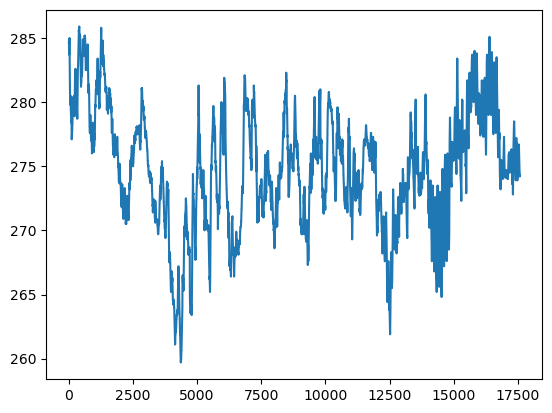

In [646]:
#t_1000hPa:K -> temperature in K 
plt.plot(X_train_estimated_a['t_1000hPa:K']) # continuous

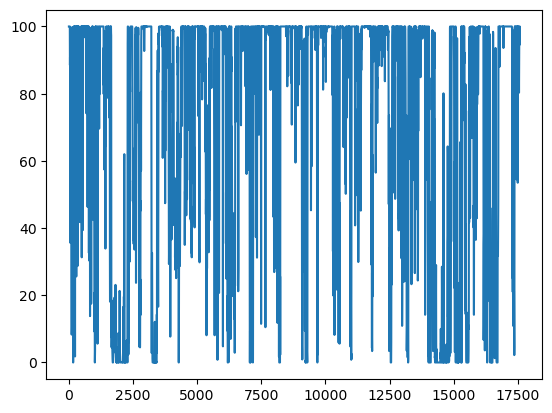

In [647]:
#total_cloud_cover:p -> % of cloud cover correlated with covered sky
plt.plot(X_train_estimated_a['total_cloud_cover:p']) # %

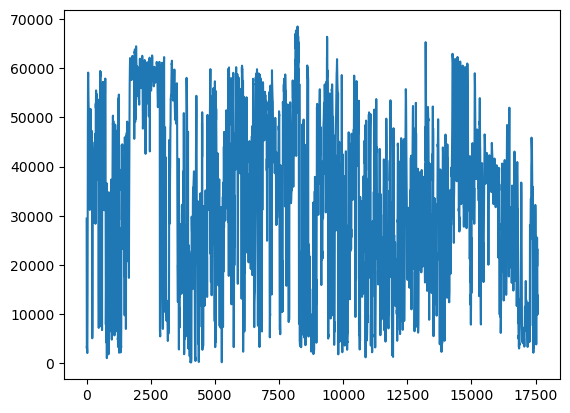

In [648]:
#visibility:m -> visibility in meters
plt.plot(X_train_estimated_a['visibility:m']) # continuous

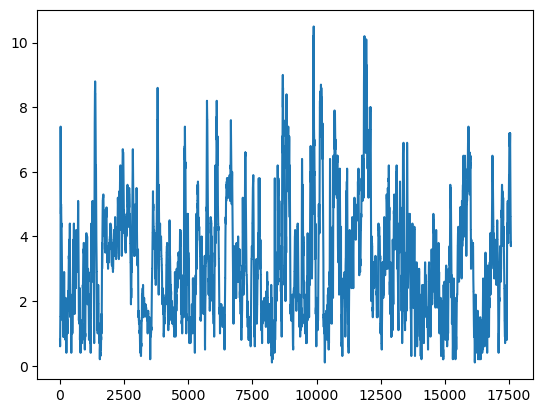

In [649]:
#wind_speed_10m:ms -> wind speed at 10m 
plt.plot(X_train_estimated_a['wind_speed_10m:ms']) # continuous

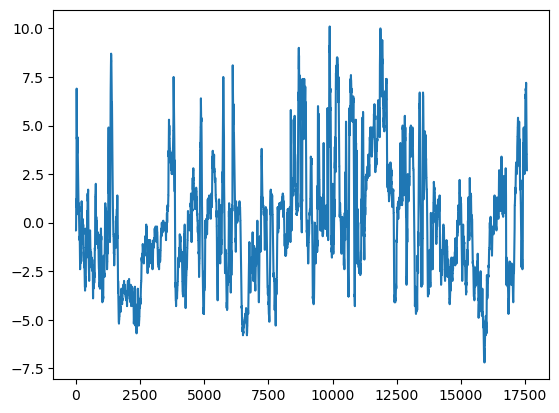

In [650]:
#wind_speed_10m:ms -> wind speed from west to east at 10m 
plt.plot(X_train_estimated_a['wind_speed_u_10m:ms']) # continuous

#same for wind_speed_v_10m:ms from south to north
#both correlated with wind speed?

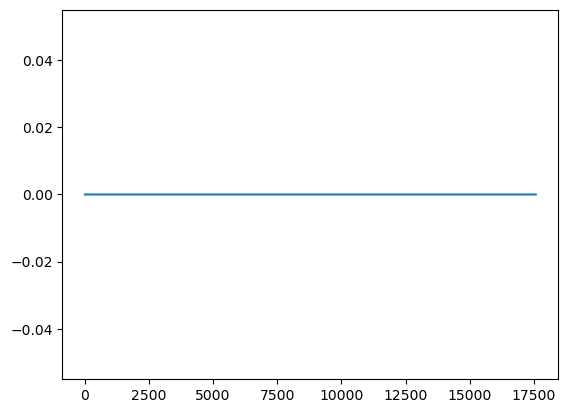

In [651]:
#wind_speed_w_1000hPa:ms -> vertical wind (maybe not significant often 0)
plt.plot(X_train_estimated_a['wind_speed_w_1000hPa:ms']) # continuous

# Correlation analysis

<Axes: >

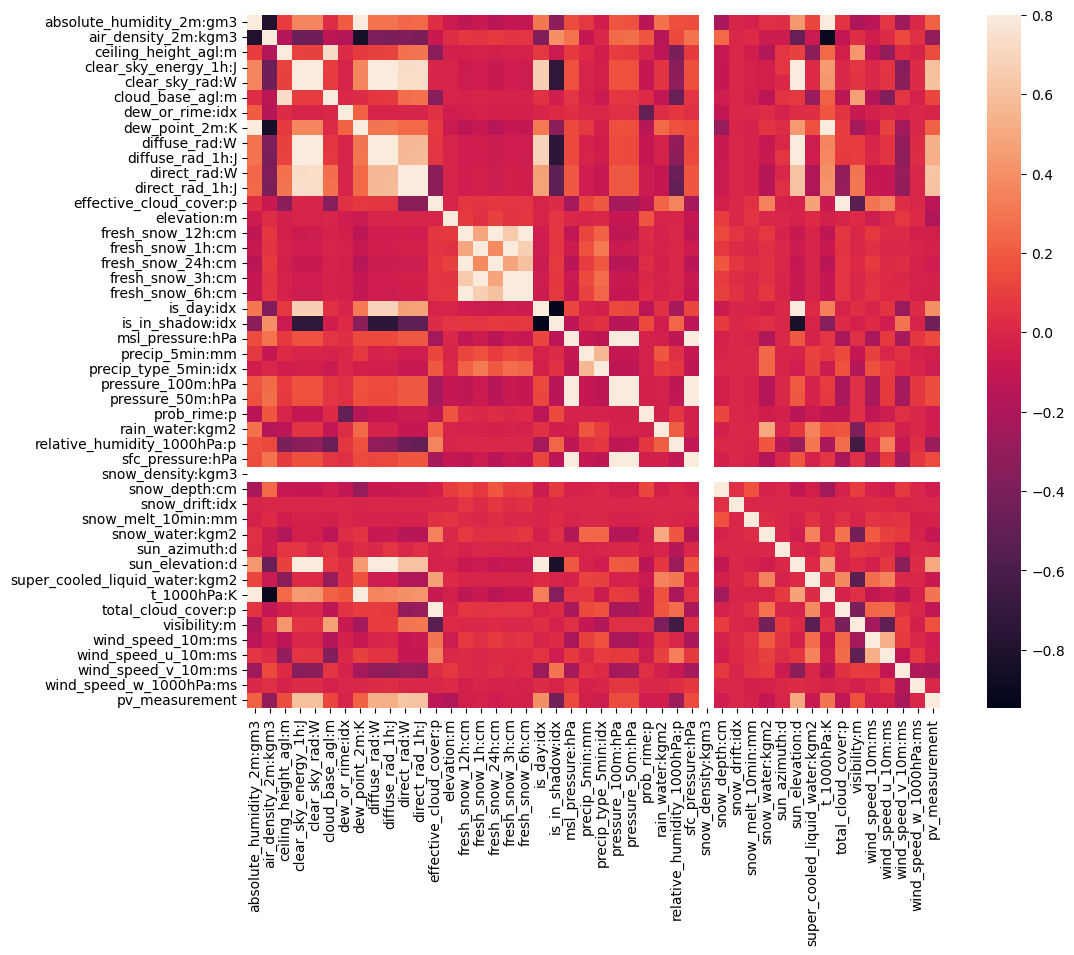

In [652]:
corrmat = all_data.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

# Groups of feature

Some features are really very related to each other as they concern the same phenomenon from different points of view, so it makes sense to merge these groups via PCA

### Humidity group
- absolute_snow_2m:gm3
- air_density_2m:kgm3
- dew_point_2m:K
- t_1000hPa:K

### Cloud height
- ceiling_height_agl:m
- cloud_base_agl:m

### Sun
- clear_sky_energy_1h:J
- clear_sky_rad:W
- diffuse_rad:W
- diffuse_rad_1h:J
- direct_rad:W
- direct_rad_1h:J
- is_day:idx
- is_in_shadow:idx
- sun_elevation:d

### Cloud cover
- effective_cloud_cover:p
- total_cloud_cover:p
- visibility:m (!correlation with many different feature!)

### Snow
- fresh_snow_12h:cm
- fresh_snow_1h:cm
- fresh_snow_24h:cm
- fresh_snow_3h:cm
- fresh_snow_6h:cm

### Pressure
- msl_pressure:hPa
- pressure_100m:hPa
- pressure_50m:hPa
- sfc_pressure:hPa

### Precipitation
- precip_5min:mm
- precip_type_5min:idx

### Rain/Snow Water
- rain_water:kgm2
- snow_water:kgm2

### Wind
- wind_speed_10m:ms
- wind_speed_u_10m:ms
- wind_speed_v_10m:ms
- wind_speed_w_1000hPa:ms

# Other comments on feature that are not in group

### dew_or_rime:idx
index that explains whether there is dew, rime or neither
correlation with prob_rime:p

### elevation:m
Is constant for every building so probably is not significant to do previsions (could it be used as a categorical to classify the three buildings?)

### relative_humidity_1000hPa:p
why is it not correlated with the other humidity indices? there is correlation with the 'Sun' group

### snow_density:kgm3
Not significant because snow depth is always < 60cm

### snow_depth:cm
Very often it is zero, it could be of little significance

### snow_melt_10min:mm
Very often it is zero, it could be of little significance

### sun_azimuth:d
It seems to be unrelated to anything. To be studied better

### super_cooled_liquid_water:kgm2
Some correlation with cloud cover group

### Visibility
This feature is related to many groups, we need to understand how to treat it


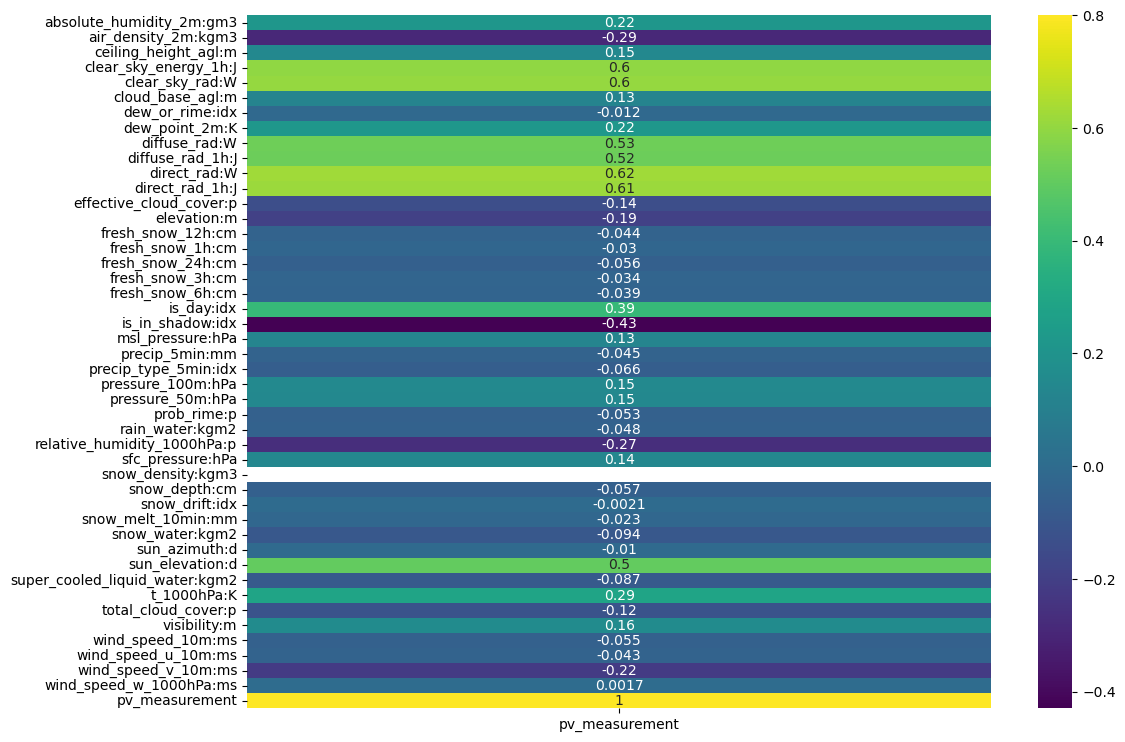

In [653]:
corr_y = all_data.corr(numeric_only=True)['pv_measurement'].to_frame()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_y, vmax=.8, cmap='viridis', annot=True);

# Pre-Processing

### Data cleaning

In [654]:
#sample without pv_measurement
all_data = all_data.dropna(subset = ['pv_measurement'],axis=0)

In [655]:
#snow density not relevant
all_data[all_data['snow_density:kgm3'] != 250]['snow_density:kgm3'].count() # = 0
all_data.drop('snow_density:kgm3',axis=1, inplace=True)

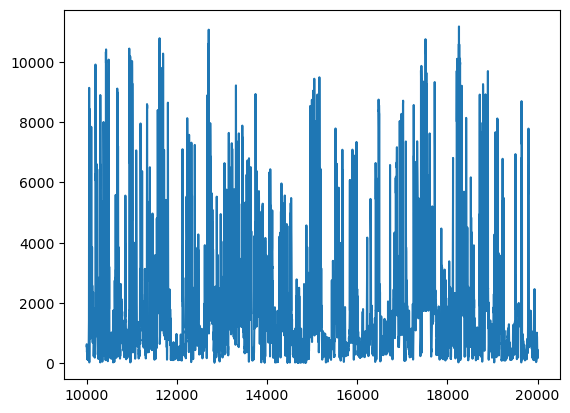

In [656]:
#cloud anc ceiling
#fill as mean, (iterative imputer)
all_data['cloud_base_agl:m'].fillna(all_data['cloud_base_agl:m'].mean(), inplace=True)
all_data['ceiling_height_agl:m'].fillna(all_data['ceiling_height_agl:m'].mean(), inplace=True)
plt.plot(all_data['cloud_base_agl:m'][10000:20000])

In [657]:
all_data.reset_index(inplace=True, drop=True)
all_data

,building_id,time_hour,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,pv_measurement
0,a,2019-06-02 22:00:00,2019-06-02 22:22:30,7.700,1.22825,1728.949951,0.000000,0.000000,1728.949951,0.0,280.299988,0.000000,0.000000,0.00,0.000000,99.074997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,1006.299988,0.0000,0.00,993.750000,999.775024,0.0,0.000,71.674995,1005.799988,0.0,0.0,0.0,0.175,348.036743,-3.774250,0.0,286.225006,100.000000,40386.476562,3.600,-3.575,-0.500,0.0,0.00
1,a,2019-06-02 23:00:00,2019-06-02 23:22:30,7.700,1.22350,1689.824951,0.000000,0.000000,1689.824951,0.0,280.299988,0.000000,0.000000,0.00,0.000000,99.750000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,1005.200012,0.0000,0.00,992.674988,998.650024,0.0,0.025,68.000000,1004.650024,0.0,0.0,0.0,0.200,91.980751,-4.357250,0.0,286.899994,100.000000,33770.648438,3.350,-3.350,0.275,0.0,0.00
2,a,2019-06-03 00:00:00,2019-06-03 00:22:30,7.875,1.21975,1563.224976,0.000000,0.000000,1563.224976,0.0,280.649994,0.000000,0.000000,0.00,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,1004.525024,0.0000,0.00,992.000000,997.974976,0.0,0.100,67.949997,1003.950012,0.0,0.0,0.0,0.400,14.934750,-3.309500,0.0,286.950012,100.000000,13595.500000,3.050,-2.950,0.750,0.0,0.00
3,a,2019-06-03 01:00:00,2019-06-03 01:22:30,8.425,1.21800,1283.425049,208.649994,0.750000,1283.425049,0.0,281.674988,0.300000,526.775024,0.00,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.25,1.00,1004.025024,0.0000,0.00,991.500000,997.449951,0.0,0.125,73.875000,1003.449951,0.0,0.0,0.0,0.550,28.630251,-0.822500,0.0,286.750000,100.000000,2321.850098,2.725,-2.600,0.875,0.0,0.00
4,a,2019-06-03 02:00:00,2019-06-03 02:22:30,8.950,1.21800,1003.500000,32468.150391,23.100000,1003.500000,0.0,282.500000,11.975000,22068.949219,0.15,282.975006,84.875000,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.00,1003.099976,0.0000,0.00,990.550049,996.500000,0.0,0.100,79.925003,1002.500000,0.0,0.0,0.0,0.250,41.997501,3.051250,0.0,286.450012,99.224998,11634.799805,2.550,-2.350,0.925,0.0,19.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82021,c,2022-04-25 17:00:00,2022-04-25 17:22:30,4.800,1.26350,963.100037,714495.875000,135.699997,652.849976,0.0,273.349976,59.724998,302639.843750,11.05,112344.523438,94.599998,24.0,0.0,0.0,0.0,0.0,0.0,1.00,0.00,1019.299988,0.0000,0.00,1003.500000,1009.674988,0.0,0.000,67.474998,1015.875000,0.0,0.0,0.0,0.000,277.333984,11.023001,0.1,277.600006,94.599998,37207.449219,3.950,2.800,-2.825,0.0,98.00
82022,c,2022-04-25 18:00:00,2022-04-25 18:22:30,4.800,1.26525,1177.599976,299217.843750,39.000000,705.099976,0.0,273.299988,21.775000,146764.953125,1.60,22766.199219,71.824997,24.0,0.0,0.0,0.0,0.0,0.0,1.00,0.75,1019.400024,0.0025,0.25,1003.599976,1009.750000,0.0,0.000,66.775002,1016.000000,0.0,0.0,0.0,0.000,290.590515,4.515250,0.0,277.600006,71.824997,36468.976562,3.375,2.475,-2.325,0.0,39.20
82023,c,2022-04-25 19:00:00,2022-04-25 19:22:30,4.900,1.26900,2835.551514,53591.675781,1.200000,652.900024,0.0,273.500000,1.150000,41283.949219,0.00,2871.024902,51.275002,24.0,0.0,0.0,0.0,0.0,0.0,0.25,1.00,1019.625000,0.0025,0.25,1003.849976,1010.049988,0.0,0.000,70.125000,1016.250000,0.0,0.0

In [658]:
def pca_analysis(df, features, feature_prefix, n_components, scalers):
    df = df.copy(deep=True)

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[features])

    pca_transformer = PCA(n_components=n_components)
    df_pca = pd.DataFrame(pca_transformer.fit_transform(df_scaled))
    df_pca.columns = [feature_prefix + "_" + str(i+1) for i in range(n_components)]

    df = df.drop(features, axis=1)
    #df = pd.concat([df, df_pca], axis=1, ignore_index=True)
    df = pd.concat([df, pd.DataFrame(df_pca)], axis=1)
    

    scalers |= {feature_prefix: {'scaler': scaler, 'pca_transformer': pca_transformer}}

    return df, scalers

In [659]:
all_data_pca = all_data.copy()
scalers = {}
all_data_pca.isna().sum()

building_id                       0
time_hour                         0
date_forecast                     0
absolute_humidity_2m:gm3          0
air_density_2m:kgm3               0
ceiling_height_agl:m              0
clear_sky_energy_1h:J             0
clear_sky_rad:W                   0
cloud_base_agl:m                  0
dew_or_rime:idx                   0
dew_point_2m:K                    0
diffuse_rad:W                     0
diffuse_rad_1h:J                  0
direct_rad:W                      0
direct_rad_1h:J                   0
effective_cloud_cover:p           0
elevation:m                       0
fresh_snow_12h:cm                 0
fresh_snow_1h:cm                  0
fresh_snow_24h:cm                 0
fresh_snow_3h:cm                  0
fresh_snow_6h:cm                  0
is_day:idx                        0
is_in_shadow:idx                  0
msl_pressure:hPa                  0
precip_5min:mm                    0
precip_type_5min:idx              0
pressure_100m:hPa           

In [660]:
"""
generic_scaler = StandardScaler()
generic_scaler.fit(all_data_pca.drop(['pv_measurement','time','building_id','date_forecast'],axis=1))
temp = generic_scaler.transform(all_data_pca.drop(['pv_measurement','time','building_id','date_forecast'],axis=1))
pca2 = PCA().fit(temp)
plt.plot(pca2.explained_variance_[1:10], linewidth=2)
plt.xlabel('Components')
plt.ylabel('Explained Variances')
plt.show()
"""

"\ngeneric_scaler = StandardScaler()\ngeneric_scaler.fit(all_data_pca.drop(['pv_measurement','time','building_id','date_forecast'],axis=1))\ntemp = generic_scaler.transform(all_data_pca.drop(['pv_measurement','time','building_id','date_forecast'],axis=1))\npca2 = PCA().fit(temp)\nplt.plot(pca2.explained_variance_[1:10], linewidth=2)\nplt.xlabel('Components')\nplt.ylabel('Explained Variances')\nplt.show()\n"

In [661]:
all_data.shape

(82026, 48)

In [662]:
for group, name, n in zip(all_groups, all_groups_names, n_pca):
    all_data_pca, scalers = pca_analysis(all_data_pca, group, name, n, scalers)

In [663]:
all_data_pca.shape

(82026, 34)

In [664]:
all_data.shape

(82026, 48)

<Axes: >

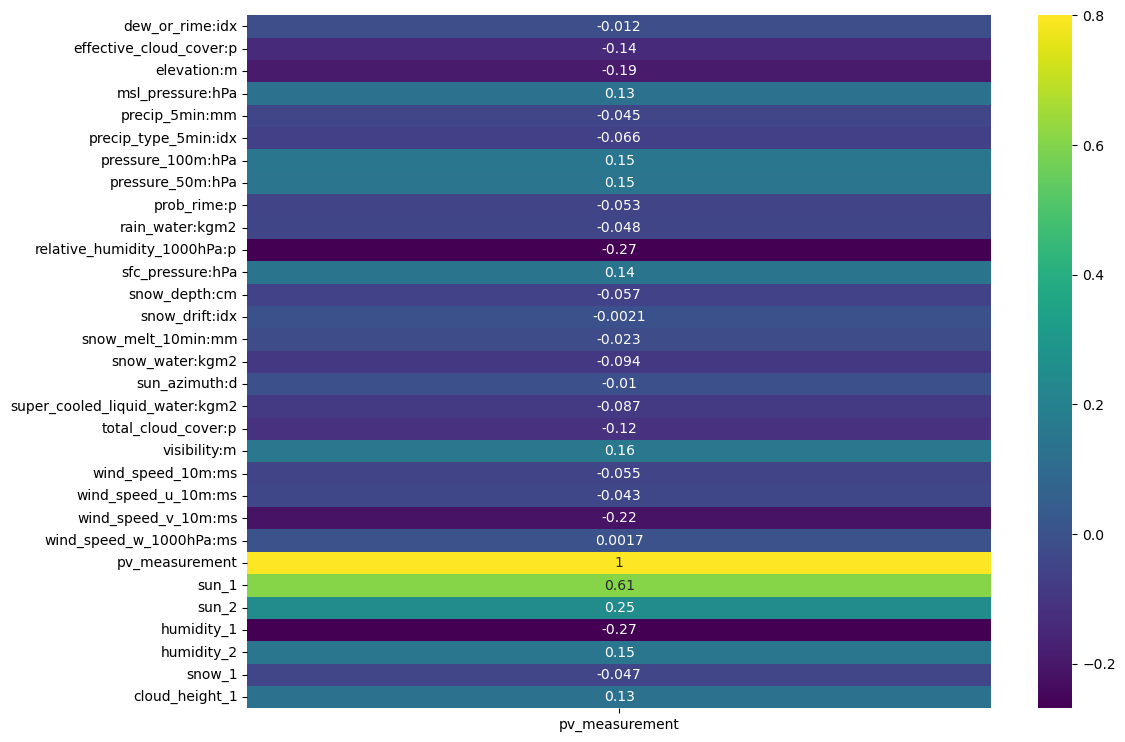

In [665]:
corr_y = all_data_pca.corr(numeric_only=True)['pv_measurement'].to_frame()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_y, vmax=.8, cmap='viridis', annot=True)


In [666]:
# drop irrelevant features from X and X_test
X = all_data.drop(['pv_measurement', 'date_forecast','time_hour'], axis=1)

#TODO turn back on
X_test_aggregated.drop(['date_forecast','date_calc','snow_density:kgm3','time_hour'],axis=1 , inplace=True)

# one hot encoding for categorical features
ohe_enc = OneHotEncoder()

X_cat = X[['building_id']]

X_cat = pd.DataFrame(ohe_enc.fit_transform(X_cat).toarray())
X = pd.concat([X.drop(['building_id'], axis=1), X_cat], axis=1)
X.columns = X.columns.map(str)

y = all_data['pv_measurement']

In [667]:
X_test_cat = X_test_aggregated[['building_id']]

X_test_cat = pd.DataFrame(ohe_enc.transform(X_test_cat).toarray())
X_test_aggregated = pd.concat([X_test_aggregated.drop(['building_id'], axis=1).reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)
X_test_aggregated.columns = X_test_aggregated.columns.map(str)
    

In [668]:
X

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,0,1,2
0,7.700,1.22825,1728.949951,0.000000,0.000000,1728.949951,0.0,280.299988,0.000000,0.000000,0.00,0.000000,99.074997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,1006.299988,0.0000,0.00,993.750000,999.775024,0.0,0.000,71.674995,1005.799988,0.0,0.0,0.0,0.175,348.036743,-3.774250,0.0,286.225006,100.000000,40386.476562,3.600,-3.575,-0.500,0.0,1.0,0.0,0.0
1,7.700,1.22350,1689.824951,0.000000,0.000000,1689.824951,0.0,280.299988,0.000000,0.000000,0.00,0.000000,99.750000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,1005.200012,0.0000,0.00,992.674988,998.650024,0.0,0.025,68.000000,1004.650024,0.0,0.0,0.0,0.200,91.980751,-4.357250,0.0,286.899994,100.000000,33770.648438,3.350,-3.350,0.275,0.0,1.0,0.0,0.0
2,7.875,1.21975,1563.224976,0.000000,0.000000,1563.224976,0.0,280.649994,0.000000,0.000000,0.00,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,1004.525024,0.0000,0.00,992.000000,997.974976,0.0,0.100,67.949997,1003.950012,0.0,0.0,0.0,0.400,14.934750,-3.309500,0.0,286.950012,100.000000,13595.500000,3.050,-2.950,0.750,0.0,1.0,0.0,0.0
3,8.425,1.21800,1283.425049,208.649994,0.750000,1283.425049,0.0,281.674988,0.300000,526.775024,0.00,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.25,1.00,1004.025024,0.0000,0.00,991.500000,997.449951,0.0,0.125,73.875000,1003.449951,0.0,0.0,0.0,0.550,28.630251,-0.822500,0.0,286.750000,100.000000,2321.850098,2.725,-2.600,0.875,0.0,1.0,0.0,0.0
4,8.950,1.21800,1003.500000,32468.150391,23.100000,1003.500000,0.0,282.500000,11.975000,22068.949219,0.15,282.975006,84.875000,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.00,1003.099976,0.0000,0.00,990.550049,996.500000,0.0,0.100,79.925003,1002.500000,0.0,0.0,0.0,0.250,41.997501,3.051250,0.0,286.450012,99.224998,11634.799805,2.550,-2.350,0.925,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82021,4.800,1.26350,963.100037,714495.875000,135.699997,652.849976,0.0,273.349976,59.724998,302639.843750,11.05,112344.523438,94.599998,24.0,0.0,0.0,0.0,0.0,0.0,1.00,0.00,1019.299988,0.0000,0.00,1003.500000,1009.674988,0.0,0.000,67.474998,1015.875000,0.0,0.0,0.0,0.000,277.333984,11.023001,0.1,277.600006,94.599998,37207.449219,3.950,2.800,-2.825,0.0,0.0,0.0,1.0
82022,4.800,1.26525,1177.599976,299217.843750,39.000000,705.099976,0.0,273.299988,21.775000,146764.953125,1.60,22766.199219,71.824997,24.0,0.0,0.0,0.0,0.0,0.0,1.00,0.75,1019.400024,0.0025,0.25,1003.599976,1009.750000,0.0,0.000,66.775002,1016.000000,0.0,0.0,0.0,0.000,290.590515,4.515250,0.0,277.600006,71.824997,36468.976562,3.375,2.475,-2.325,0.0,0.0,0.0,1.0
82023,4.900,1.26900,2835.551514,53591.675781,1.200000,652.900024,0.0,273.500000,1.150000,41283.949219,0.00,2871.024902,51.275002,24.0,0.0,0.0,0.0,0.0,0.0,0.25,1.00,1019.625000,0.0025,0.25,1003.849976,1010.049988,0.0,0.000,70.125000,1016.250000,0.0,0.0,0.0,0.000,303.984009,-1.445250,0.0,277.399994,51.275002,35756.851562,3.100,2.400,-1.900,0.0,0.0,0.0,1.0
82024,5.150,1.27575,2835.551514,334.100006,0.000000,602.474976,0.0,274.149994,0.000000,2063.925049,0.00,0.000000,47.375000,24.0,0.0,0.0,0.0,0.0,0.0,0.00,1.00,1019.849976,0.0000,0.00,1004.174988,1010.400024,0.0,0.000,78.500000,1016.650

# Modeling

In [672]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=20, random_state=42)

random_forest.fit(X, y)

RandomForestRegressor(n_estimators=20, random_state=42)

In [673]:

X_test_aggregated['cloud_base_agl:m'].fillna(X_test_aggregated['cloud_base_agl:m'].mean(), inplace=True)
X_test_aggregated['ceiling_height_agl:m'].fillna(X_test_aggregated['ceiling_height_agl:m'].mean(), inplace=True)



test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test['prediction'] = random_forest.predict(X_test_aggregated)
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)